<h1>FDA HW3</h1>

<h4>使用以下三種 Model 對股票的漲跌進行預測、比較預測結果：</h4>
    
1.Logistic Regression

2.Support Vector Machine

3.Neural Network

並對個別 Model 調整參數，觀察預測準確度的變化。

In [1]:
import numpy as np # linear algebra
np.set_printoptions(threshold=np.inf)
import scipy as sp 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Visualization
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics

<h2>Data & preprocessing</h2>

In [2]:
stock_data = pd.read_csv('./stock.csv')
stock_data.head(10)

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952
5,09-Jan-2009,909.91,890.35,911.93,888.31,4716499968
6,12-Jan-2009,890.40,870.26,890.40,864.32,4725049856
7,13-Jan-2009,869.79,871.79,877.02,862.02,5017469952
8,14-Jan-2009,867.28,842.62,867.28,836.93,5407880192
9,15-Jan-2009,841.99,843.74,851.59,817.04,7807350272


原始的 Dataset 中，所包含的性質有：

Date:時間

Open Price :   開盤價格

Close Price:   收盤價格

High Price :   當日高點

Low Price  :   當日低點

Volume     :   成交量

但我們關心的資料為漲跌的趨勢，所以新增一個欄位"up_down"用來存放隔天的漲跌情形。
其中 1 : up ，0 : down 由比較第 i 日與第 i+1 日收盤價格而得，而 index i 
的"up_down"欄位中從放的是 **隔日** 的漲跌情形。
(一開始在這個步驟做錯了，將第 i 日的漲跌資料放在 index i 的"up_down"欄位中，
想說怎麼預測準確率有 8x% ，本來以為是Model的參數設定有誤，在反覆檢查後才發現問
題出在最前面。要是準確率有那麼高就好了.....)

In [31]:
up_down = np.zeros(len(stock_data))
price_diff = np.zeros(len(stock_data))
countup = 0
for i in range(len(up_down)-1):
    if(stock_data.iloc[i,2] < stock_data.iloc[i+1,2]):
        up_down[i] = 1
        countup += 1
    price_diff[i] = stock_data.iloc[i,2] - stock_data.iloc[i,1]
#print(countup/len(up_down))

又因為要將2018年的資料獨立出來做 test Data 所以用 dataframe 中的 function 將 year 分割出來方便檢索

同時加入了 "price_diff" 這個欄位紀錄當天的價格變化(由 Open Price - Close Price 得到）

In [29]:
stock_data['up_down'] = up_down
stock_data['price_diff'] = price_diff
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['year'] = stock_data['Date'].dt.year
stock_data.head(10)

,Date,Open Price,Close Price,High Price,Low Price,Volume,up_down,price_diff,year
0,2009-01-02,902.99,931.80,934.73,899.35,4048270080,0.0,28.81,2009
1,2009-01-05,929.17,927.45,936.63,919.53,5413910016,1.0,-1.72,2009
2,2009-01-06,931.17,934.70,943.85,927.28,5392620032,0.0,3.53,2009
3,2009-01-07,927.45,906.65,927.45,902.37,4704940032,1.0,-20.80,2009
4,2009-01-08,905.73,909.73,910.00,896.81,4991549952,0.0,4.00,2009
5,2009-01-09,909.91,890.35,911.93,888.31,4716499968,0.0,-19.56,2009
6,2009-01-12,890.40,870.26,890.40,864.32,4725049856,1.0,-20.14,2009
7,2009-01-13,869.79,871.79,877.02,862.02,5017469952,0.0,2.00,2009
8,2009-01-14,867.28,842.62,867.28,836.93,5407880192,1.0,-24.66,2009
9,2009-01-15,841.99,843.74,851.59,817.04,7807350272,1.0,1.75,2009


由下圖可看出來，從2009~2018年，這支股票價格的是逐漸攀升的，但長期來看股價上升，並不代表 **漲的天數** 較多

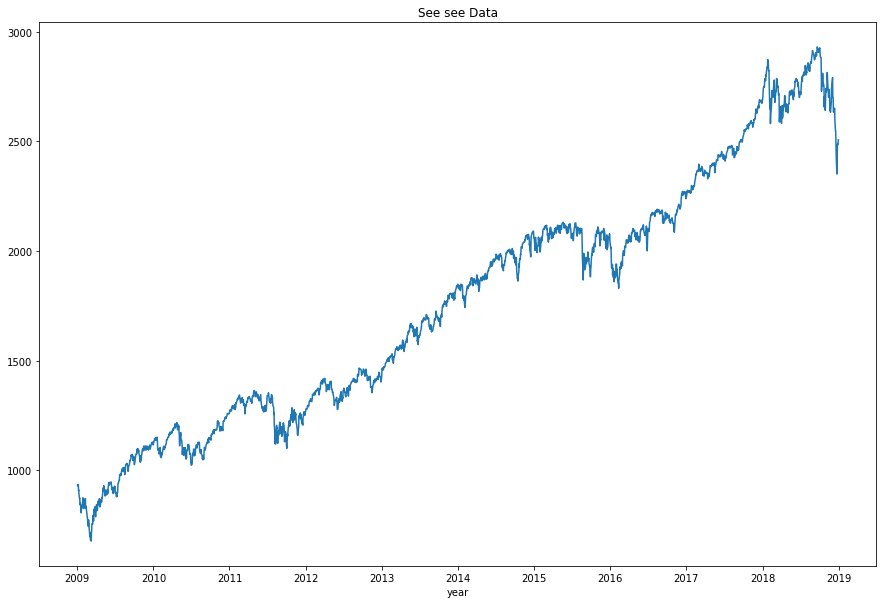

In [30]:
plt.figure(figsize=(15,10))
plt.plot_date(stock_data['Date'], stock_data['Close Price'], '-')
plt.title('See see Data')
plt.xlabel('year')
plt.show()

這邊稍微做了統計，分別紀錄 2009~2017 、 2018 的漲跌天數比例，可以看出來漲的天數的確較多

但卻不像上面的圖那麼樂觀，漲的天數比例不比跌的高上太多。

In [34]:
stock_train = stock_data[stock_data['year']!=2018]
stock_test = stock_data[stock_data['year']==2018]
print("training data:")
print(stock_train['up_down'].value_counts()/len(stock_train))
print("testing data:")
print(stock_test['up_down'].value_counts()/len(stock_test))

training data:
1.0    0.546378
0.0    0.453622
Name: up_down, dtype: float64
testing data:
1.0    0.519841
0.0    0.480159
Name: up_down, dtype: float64


<h2>Regression</h2>

這邊開始引入第一個模型：Regression(迴歸)

這裡採用的是 LogisticRegression，首先先不排除任何欄位，

所有 feature 作 Regression 的結果是幾乎所有的預測都是1，

預測的準確率也就與上面統計漲跌天數比例的機率將近。

In [33]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

train_x = stock_train[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume','price_diff']]
train_y = stock_train['up_down']

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)
#print(log_reg.coef_)
test_x = stock_test[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume','price_diff']]
test_y = stock_test['up_down']
log_predict = log_reg.predict(test_x)
print(log_predict)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(test_y, log_predict))

Accuracy: 0.5198412698412699


接下來試著只對特定幾項 feature 做回歸，

一開始猜今日的漲幅可能影響到隔天的漲跌情形。

例如如果今天大漲，明天繼續看漲的機率就高，

如果今天股價大跌，則明天可能漲的機率也不高。

可以看到以 "price_diff"(漲幅) 做回歸模型預測的準確率較剛剛稍微高一點。

而已當日成交量作回歸模型，準確率則與先前一樣。

In [9]:
train_x_priceDiff = stock_train[['price_diff']]
test_x_priceDiff = stock_test[['price_diff']]
log_reg_priceDiff = LogisticRegression()
log_reg_priceDiff.fit(train_x_priceDiff, train_y)
log_predict_priceDiff = log_reg_priceDiff.predict(test_x_priceDiff)
print("Accuracy:",accuracy_score(test_y, log_predict_priceDiff))

Accuracy: 0.5238095238095238


In [36]:
train_x_Vol = stock_train[['Volume']]
test_x_Vol = stock_test[['Volume']]
log_reg_Vol = LogisticRegression()
log_reg_Vol.fit(train_x_Vol, train_y)
log_predict_Vol = log_reg_Vol.predict(test_x_Vol)
print("Accuracy:",accuracy_score(test_y, log_predict_Vol))

Accuracy: 0.5198412698412699


<h2>Support Vector Machine</h2>

這邊引入第二個模型：SVM

突然發現先前忘記將 Data 作 Scaler

這裡會順便比較有無經過 Scaler ，最後準確率的差異。

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm

train_x_std = stock_train[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume','price_diff']]

scaler = StandardScaler()
scaler.fit(train_x_std)

test_x_std = stock_test[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume','price_diff']]

train_x_std = scaler.transform(train_x_std)
test_x_std = scaler.transform(test_x_std)
#print((test_x_std))

/home/acnes2/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/acnes2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/home/acnes2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


首先一樣測試最基本的 SVM 模型，所有參數能不設的就不設，

全部採用 Default 值。得到的結果不比先前的 Regression 所得到

的準確率高。

In [38]:
svm_model = svm.SVC()
svm_model = svm_model.fit(train_x_std, train_y)
svm_predict_train = svm_model.predict(train_x_std)
svm_predict_test = svm_model.predict(test_x_std)

print("Accuracy of training data:",accuracy_score(train_y, svm_predict_train))
print("Accuracy of testing data:",accuracy_score(test_y, svm_predict_test))


Accuracy of training data: 0.5618374558303887
Accuracy of testing data: 0.5158730158730159


這裡開始試著調整參數，包括提高 Penalty、iteration 深度不限、提高 degree，

但令人百思不得其解的是，這個模型雖然更貼近 training data，但在 testing data

的表現卻比原先還差。回頭看了原始的資料發現，2018(testing data)的股價趨勢，與先前

的走向大有不同，也難怪用 SVM 的準確率比 Regression 還差。

(推測模型愈接近原來的 Training data 則會離 testing data 愈遠）


In [40]:
svm_model2 = svm.SVC(C=3, probability = True, max_iter=-1, degree=5)
svm_model2 = svm_model2.fit(train_x_std, train_y)
svm_predict_train2 = svm_model2.predict(train_x_std)
svm_predict_test2 = svm_model2.predict(test_x_std)

print("Accuracy of training data:",accuracy_score(train_y, svm_predict_train2))
print("Accuracy of testing data:",accuracy_score(test_y, svm_predict_test2))

Accuracy of training data: 0.5631625441696113
Accuracy of testing data: 0.47619047619047616


一樣試著調整 SVM 模型的參數，首先是調整 Penalty，

在 Peanlty 提高後(1->1.5)，可以看到準確率稍微下降。

In [44]:
svm_model3 = svm.SVC(C = 1.5)
svm_model3 = svm_model3.fit(train_x_std, train_y)
svm_predict_train3 = svm_model3.predict(train_x_std)
svm_predict_test3 = svm_model3.predict(test_x_std)

print("Accuracy of training data:",accuracy_score(train_y, svm_predict_train3))
print("Accuracy of testing data:",accuracy_score(test_y, svm_predict_test3))

Accuracy of training data: 0.5627208480565371
Accuracy of testing data: 0.5079365079365079


接著減少 feature 的數量，這次拿掉了 Volume 等欄位，

保留當日高低價與當日漲幅，此次的準確率一樣不到 50% ，

也比使用同樣 feature 的 Regression 模型的準確率還低。

In [45]:
train_x_less = stock_train[['High Price', 'Low Price','price_diff']]
test_x_less = stock_test[['High Price', 'Low Price','price_diff']]
scalerr = StandardScaler()
scalerr.fit(train_x_less)

train_x_less = scalerr.transform(train_x_less)
test_x_less = scalerr.transform(test_x_less)

svm_model_less = svm.SVC()
svm_model_less = svm_model_less.fit(train_x_less, train_y)
svm_predict_train_less = svm_model_less.predict(train_x_less)
svm_predict_test_less = svm_model_less.predict(test_x_less)

print("Accuracy of training data:",accuracy_score(train_y, svm_predict_train_less))
print("Accuracy of testing data:",accuracy_score(test_y, svm_predict_test_less))

Accuracy of training data: 0.5552120141342756
Accuracy of testing data: 0.49603174603174605


最後比較有無對資料進行 Scaler 對於 SVM 建立模型並預測的準確率的影響

驚訝的發現，它的準確率與使用 Regression 的準確率一樣。

可能因為 Volume 的值與其他欄位相比太過極端，導致未經 Scaler 的資料，

不管用什麼模型，結果都相去不遠。

In [46]:
svm_predict_train = svm_model.predict(train_x)
svm_predict_test = svm_model.predict(test_x)
print("Accuracy of training data(without scaler):",accuracy_score(train_y, svm_predict_train))
print("Accuracy of testing data(without scaler):",accuracy_score(test_y, svm_predict_test))

Accuracy of training data(without scaler): 0.5463780918727915
Accuracy of testing data(without scaler): 0.5198412698412699


<h2>Neural Network</h2>

最後一個模型是 Neural Network ，一開始測試一層 Hidden Layer 的網路，

其中含有 100 個 units。這個模型的準確率依舊只比 50% 多上一些。

In [47]:
from keras import models, layers, optimizers, regularizers,utils

model = models.Sequential()
model.add(layers.Dense(input_dim = 6,units = 100,activation='sigmoid'))
model.add(layers.Dense(units = 1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')
model.summary()
history = model.fit(train_x_std, train_y, epochs=100, verbose=False)
neural_predict = model.predict_classes(test_x_std)
print(accuracy_score(test_y, neural_predict))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               700       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
0.5238095238095238


這邊試著多加入一層 Hidden Layer，並且調整各層 units 數量，activation func 不變，

得到的結果反而比先前還差，這讓我更加懷疑，是不是其實愈符合原來 training data 的資料，

愈難在 testing data 中取得好的準確率?

In [48]:
model = models.Sequential()
model.add(layers.Dense(input_dim = 6,units = 20,activation='sigmoid'))
model.add(layers.Dense(units = 50,activation='sigmoid'))
model.add(layers.Dense(units = 1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')
model.summary()
history = model.fit(train_x_std, train_y, epochs=100, verbose=False)
neural_predict = model.predict_classes(test_x_std)
print(accuracy_score(test_y, neural_predict))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 20)                140       
_________________________________________________________________
dense_33 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________
0.4722222222222222


在 hidden layer與 Units 數量不變的情況下，更換 activation function，

發現準確率再度降低，因為對各種 activation function 不慎熟悉，我想得要另外

投入時間研究這些函數，才能理解準確率改變背後所代表的意義。

In [27]:
model = models.Sequential()
model.add(layers.Dense(input_dim = 6,units = 20,activation='relu'))
model.add(layers.Dense(units = 50,activation='relu'))
model.add(layers.Dense(units = 1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')
model.summary()
history = model.fit(train_x_std, train_y, epochs=100, verbose=False)
neural_predict = model.predict_classes(test_x_std)
print(accuracy_score(test_y, neural_predict))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 20)                140       
_________________________________________________________________
dense_25 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________
0.4444444444444444


<h2>Discussion</h2>

<h3>How did you preprocess this dataset ?</h3>

除了加上當日漲跌這個 target 資料外，我還加了每日漲幅這個直觀的欄位，並且利用 Scaler 對資料進行標準化。

但對於當日高低價這兩個欄位我沒有太多的想法，若能對這些欄位進行預先處理，我想準確率能再提升一些。

<h3>Which classifier reaches the highest classification accuracy in this dataset ?</h3>

一層 Neural Network 有最高的準確率，但在提高了層數與 Units 數量後，理應提高的準確率卻減少了，有可能是我在調整參數上

有疏忽，也可能是2018年的走向與前十年的走向差異太大，導致以 2009~2017 年間資料 train 出的 model 準確度不如預期，甚至

增加層數還可能導致準確率下降。

<h3>How did you improve your classifiers ?</h3>
    
針對不同的參數如layer層數、units個數、svm 的 degree、進行回歸分析的 feature 等做調整，並觀察結果。